In [139]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Q1

a) pre-processing data

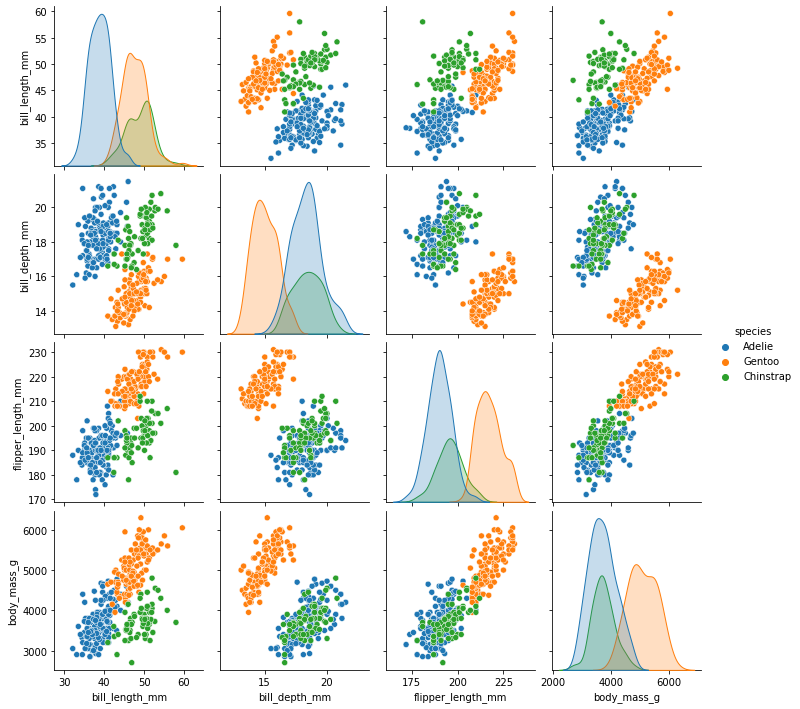

In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
encode = LabelEncoder()

data_q1=pd.read_csv('/content/drive/MyDrive/Lab_2/penguins.csv')
data_q1=data_q1.dropna(axis=0)
data_q1=data_q1.drop('year',axis=1)
sns.pairplot(data=data_q1, hue = 'species')
plt.show(sns)

In [141]:
def encode_data(data):
    y=data.columns
    for i in y:
        if(type(data[i][0])==type("2")):
            x=encode.fit_transform(data[i])
            data[i]=x

    return(data)
data_q1=encode_data(data_q1)

In [142]:
def split_data(data,frac_training,frac_testing):
    training_data = data.sample(frac = frac_training)
    testing_data= data.drop(training_data.index)
    return(training_data,testing_data)

training_data_q1,testing_data_q1=split_data(data_q1,0.75,0.25)

b) Cost function

In [143]:
def entropy_data(data):
    value,counts=np.unique(data,return_counts=True)
    entropy = 0
    for i in range (0,len(value)):
        p = (counts[i])/np.sum(counts)
        entropy = entropy - (p * np.log2(p))
    return(entropy)

In [144]:
def cost_data(data,split_feature,target_class): # to calculate cost for a feature 
    element,counts=np.unique(data[split_feature],return_counts=True)
    cost = 0
    for i in range(0,len(element)):
        sub_data = data.where(data[split_feature]==element[i]).dropna()[target_class] # sub_data to be send for entropy calculation
        weight = counts[i]/np.sum(counts)
        temp=(weight) * entropy_data(sub_data) # weighted entropy for a particular branch of a feature
        cost=cost+temp
    return(cost)

In [145]:
def infogain(data,split_feature,target_class):
    total_entropy=entropy_data(data[target_class])
    weight_entropy=cost_data(data,split_feature,target_class)
    return(total_entropy-weight_entropy )

c) Continous to catgorical

In [146]:
def categorical(data,ind,col,target):
    tl=len(data[col])
    entro_min=2**30
    j=0
    for i in data[col]:
        entropy1=entropy_data(data.where(data[col]>i).dropna()[target])
        entropy2=entropy_data(data.where(data[col]<=i).dropna()[target])
        l = len(data.where(data[col]>i).dropna()[target])
        entro= ((l/tl)*entropy1) + (((tl-l)/tl)*entropy2)
        if(entro < entro_min):
          entro_min=entro
          j=i
    copy_data=data.to_numpy()

    # print(j,entro_min)
    for i in range(0,tl):
        if(copy_data[i][ind]>j):
            copy_data[i][ind]=1
        else:
            copy_data[i][ind]=0
    updated_data=pd.DataFrame(copy_data,columns=data.columns)
    return(updated_data,j)
def cont_to_cat(data):
    target='species'
    y=['bill_length_mm', 'bill_depth_mm','flipper_length_mm', 'body_mass_g']
    a=[2,3,4,5]
    threshold_cont_to_cat=[]
    for col in range (0,len(y)):
        data,thres=categorical(data,a[col],y[col],target)
        threshold_cont_to_cat.append(thres)
    return(data,threshold_cont_to_cat)
train1,threshold_list=cont_to_cat( training_data_q1 )

In [147]:
def test_cont_to_cat(data,threshold):
    y=['bill_length_mm', 'bill_depth_mm','flipper_length_mm', 'body_mass_g']
    a=[2,3,4,5]
    copy_data=data.to_numpy()
    for col in range (0,len(y)):
        
        ind=a[col]
    # print(j,entro_min)
        for i in range(0,len(data)):
            if(copy_data[i][ind]>threshold[col]):
                copy_data[i][ind]=1
            else:
                copy_data[i][ind]=0
    updated_data=pd.DataFrame(copy_data,columns=data.columns)
    return( updated_data )
test1=test_cont_to_cat(testing_data_q1,threshold_list)

d) + e) training function with helper functions

helper function 

In [148]:
def find_best_attribute(data,feature_space,target):
    
    best_attribute= target
    max_infogain = -1
    for i in feature_space:
        if(i!=target):
            new_infogain= infogain(data,i,target)
            if(new_infogain>=max_infogain):
                max_infogain=new_infogain
                best_attribute=i
    return(best_attribute,max_infogain)
def split_data_on_feature(data,attribute,value):
    sub_data=data.where(data[attribute]==value).dropna()
    return(sub_data)
def depth_check(depth,max_depth=4):
    if(depth>max_depth):
      return(0)
    return(1)
def check_info_gain(max_info,threshold_ig=0.05):
    if(max_info< threshold_ig):
            return(0)
    return(1)

training function

In [149]:
def decision_tree_making(data,original_training_data,feature_space,target,depth):

    x=np.unique(data[target],return_counts=True)
    class_with_max_frequency=x[0][np.argmax(x[1])]
    if(len(feature_space)==0 or (depth_check(depth)==0)):
        # if number of feature or attribute left is equal to 
        return(class_with_max_frequency)
    elif(len(data)==0):
        # if there is no data for this branch than return class with max frequency in original training data
        return(np.argmax(np.unique(original_training_data[target],return_counts=True)[1]))
    elif(len(x[0])<=1):
        # if number of classes in data equal to 1
        return(x[0][0])
    else:
        best_split_attribute, max_info= find_best_attribute(data,feature_space,target)
        value=np.unique(data[best_split_attribute])
        tree={best_split_attribute:{} }
        sub_feature_space=[]
        for i in feature_space:
            if(i!=best_split_attribute):
                sub_feature_space.append(i)
        depth+=1
        if(check_info_gain(max_info)==0):
            return(class_with_max_frequency)
        else:
            for i in value:
              sub_data=split_data_on_feature(data,best_split_attribute,i)
              subtree= decision_tree_making(sub_data, original_training_data,sub_feature_space,target,depth)
              tree[best_split_attribute][i]=subtree
    return(tree)
col=train1.columns
tree1 = decision_tree_making(train1,train1,col[1:],col[0],0)
print(tree1)

{'flipper_length_mm': {0.0: {'bill_length_mm': {0.0: 0.0, 1.0: {'island': {0.0: 0.0, 1.0: 1.0, 2.0: 0.0}}}}, 1.0: {'island': {0.0: 2.0, 1.0: {'bill_length_mm': {0.0: 0.0, 1.0: 1.0}}, 2.0: 0.0}}}}


f) classification 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]


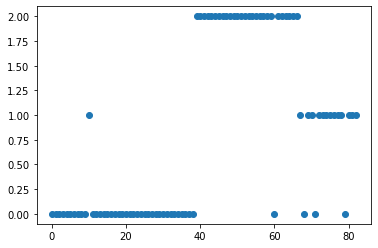

In [150]:
import matplotlib.pyplot as plt
def prediction(tree,x,col,default=0):
    if(isinstance(tree,dict)==False):
        return(tree)
    else:
        head=list(tree.keys())[0]
        if(x[col.index(head)] in tree[head].keys()):
          sub_tree=tree[head][x[col.index(head)]]
          return(prediction(sub_tree,x,col))
    return(0)
def predict_on_data(tree,data): 
  #  data has no label as species
    col=data.columns
    col=list(col)
    converted_data=data.to_numpy()
    prediction_list=[]
    for j in range(0,len(converted_data)):
        prediction_list.append(prediction(tree,converted_data[j],col))
    return(prediction_list)

actual_species=list(test1['species'])
test1.drop(['species'],axis=1)
predicted_species=predict_on_data(tree1,test1)
print(predicted_species)
x=range(0,len(predicted_species))
plt.scatter(x, predicted_species)
plt.show()

g) accuracy check

Total Accuracy is  93.97590361445783  %
Accuracy of species  0  is  97.43589743589743  %
Accuracy of species  1  is  81.25  %
Accuracy of species  2  is  96.42857142857143  %


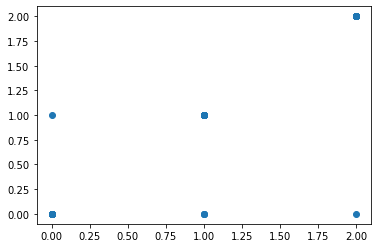

In [151]:
def total_accuracy(predicted_species,actual_species):
    correct_prediction=0
    for i in range(0,len(predicted_species)):
        if(predicted_species[i]==actual_species[i]):
            correct_prediction+=1
    print("Total Accuracy is ",(correct_prediction*100)/len(predicted_species)," %")
def classwise_accuracy(predicted_species,actual_species):
    original_count=np.unique(actual_species,return_counts=True)[1]
    correct_prediction=[0,0,0]
    for i in range(0,len(predicted_species)):
        if(predicted_species[i]==actual_species[i]):
            correct_prediction[int(predicted_species[i])]+=1
    for i in range(0,len(np.unique(actual_species))):
        print("Accuracy of species ",i," is ",(correct_prediction[i]*100)/original_count[i]," %")
total_accuracy(predicted_species,actual_species)
classwise_accuracy(predicted_species,actual_species)
plt.scatter(actual_species, predicted_species)
plt.show()

Q2

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.metrics import mean_squared_error as mse
from sklearn import tree
data_q2=pd.read_csv('/content/drive/MyDrive/Lab_2/ENB2012_data.xlsx - Φύλλο1.csv')


a) Pre-processing and spliting of input data

In [153]:
data_q2=data_q2.dropna(axis=0)


In [154]:
def split_data_2(data_q2):
    train_valid_data_q2 = data_q2.sample(frac = 0.8)
    testing_data_q2 = data_q2.drop(train_valid_data_q2.index)
    training_data_q2= train_valid_data_q2.sample(frac=(7/8))
    validation_data_q2= train_valid_data_q2.drop(training_data_q2.index)

    x_train=training_data_q2.drop(columns='Y1')
    x_valid=validation_data_q2.drop(columns='Y1')
    x_test=testing_data_q2.drop(columns='Y1')

    y_train=training_data_q2[['Y1']]
    y_valid=validation_data_q2[['Y1']]
    y_test=testing_data_q2[['Y1']]
    return(x_train,x_valid,x_test,y_train,y_valid,y_test)
x_train,x_valid,x_test,y_train,y_valid,y_test=split_data_2(data_q2)

b) finding optimal hyperparameters for regression

In [155]:
def optimal_hyperparameter(x_train,x_valid,x_test,y_train,y_valid,y_test):
      min_mse=100
      optimal_depth=0
      optimal_split=0
      for mx_depth in range(1,15):
          for mn_split in range(9,50):
              model_dtr=DTR(max_depth=mx_depth,min_samples_split=mn_split)
              model_dtr.fit(x_train,y_train)
              y_pred=model_dtr.predict(x_valid)
              current_mse=mse(y_valid,y_pred)
              if(current_mse < min_mse):
                  min_mse = current_mse
                  optimal_depth=mx_depth
                  optimal_split=mn_split
      return(optimal_depth,optimal_split)       
(optimal_depth,optimal_split)=optimal_hyperparameter(x_train,x_valid,x_test,y_train,y_valid,y_test)
print(optimal_depth,optimal_split)

7 9


c) Cross-validation, mse on testing data and printing the regression decision tree

cross-validation

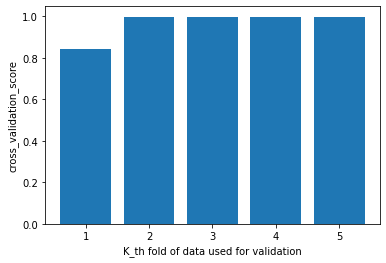

In [156]:
from sklearn.model_selection import cross_val_score

k=5
regression_dt= DTR(max_depth= optimal_depth ,min_samples_split= optimal_split)

cross_validation_score = cross_val_score(regression_dt, X=data_q2.iloc[:,0:8],y=data_q2["Y1"], cv=k, n_jobs=1)
plt.bar([i for i in range(1,6)],cross_validation_score)
plt.xlabel("K_th fold of data used for validation")
plt.ylabel("cross_validation_score")
plt.show()

Mse of regression decision tree (with optimal hyperparameter) on testing data

In [157]:
final_regression_dt = DTR(criterion="squared_error",max_depth=6,splitter="best")
final_regression_dt.fit(x_train,y_train)

print("Mean square error obtained after using the optimal depth is: {}".format(mse(y_test,final_regression_dt.predict(x_test))))

Mean square error obtained after using the optimal depth is: 0.3589755090990024


Printing tree

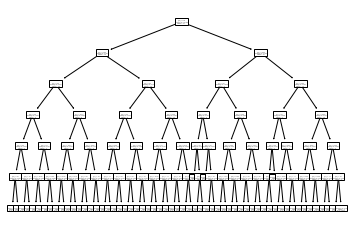

In [158]:
plt.show(tree.plot_tree(final_regression_dt ))